In [29]:
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#! pip install lightgbm
#!pip install altair

In [93]:
data = pd.read_csv('TrainingWiDS2021.csv',index_col=0)
t_data = pd.read_csv('UnlabeledWiDS2021.csv',index_col=0)
data_dictionary = pd.read_csv("DataDictionaryWiDS2021.csv")

joined_data = data.append(t_data)

In [97]:
column_datatype_mapping = dict(zip(data_dictionary['Variable Name'], data_dictionary['Data Type']))

all_data = data.drop(['encounter_id', 
                          'hospital_id', 
                          'diabetes_mellitus'], axis=1).append(t_data)

## Encoding for the categorical features

In [98]:
cat_cols = []
cont_cols = []
for col in all_data.columns:
    if all_data.dtypes[col] == "object":
        cat_cols.append(col)
        all_data[col] = all_data[col].fillna("NA")
        all_data[col] = LabelEncoder().fit_transform(all_data[col])
        all_data[col]= all_data[col].astype('category')
    elif column_datatype_mapping[col] == "binary":
        all_data[col] = all_data[col].fillna(-1)
    elif column_datatype_mapping[col] == "numeric":
        all_data[col] = all_data[col].fillna(0)
        cont_cols.append(col)
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())
        cont_cols.append(col)

In [103]:
X = all_data[:len(data)][0:120000]
y = data['diabetes_mellitus'][0:120000]

X_holdout = all_data[:len(data)][120000:]
y_holdout =  data['diabetes_mellitus'][120000:]

X_pred = all_data[len(data):].reset_index(drop=True)

In [104]:
# Splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                      test_size = 0.3, random_state = 123, stratify=y) 

In [59]:
#!pip3 install wandb
#!wandb login

In [105]:
import wandb
from wandb.lightgbm import wandb_callback

wandb.init(project="wids_2021", sync_tensorboard=True)
config = wandb.config

val_auc,0.86757
_step,199
_runtime,13
_timestamp,1610821855


val_auc,▁▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████


wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## LightGBM

In [106]:
params = {'learning_rate':0.05,
          'num_leaves':30,
          'n_estimators':200,
          'metric': 'auc',
          'objective': 'binary',
          'scale_pos_weight': 2}

watchlist = [(X_train, 'train'), (X_test, 'test')]
num_round = 5

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [107]:
# train

wandb.config.update(params)

# add lightgbm callback
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                valid_names=('val'),
                callbacks=[wandb_callback()],
                early_stopping_rounds=10)

# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
#print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 18173, number of negative: 65827
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25218
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 176


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216345 -> initscore=-1.287093
[LightGBM] [Info] Start training from score -1.287093
[1]	val's auc: 0.809932
Training until validation scores don't improve for 10 rounds
[2]	val's auc: 0.815161
[3]	val's auc: 0.820339
[4]	val's auc: 0.821786
[5]	val's auc: 0.823949
[6]	val's auc: 0.825622
[7]	val's auc: 0.826637
[8]	val's auc: 0.82764
[9]	val's auc: 0.82824
[10]	val's auc: 0.829291
[11]	val's auc: 0.829956
[12]	val's auc: 0.830795
[13]	val's auc: 0.831469
[14]	val's auc: 0.831858
[15]	val's auc: 0.832297
[16]	val's auc: 0.832733
[17]	val's auc: 0.833619
[18]	val's auc: 0.834136
[19]	val's auc: 0.834648
[20]	val's auc: 0.835367
[21]	val's auc: 0.835728
[22]	val's auc: 0.836186
[23]	val's auc: 0.836748
[24]	val's auc: 0.837433
[25]	val's auc: 0.837971
[26]	val's auc: 0.83842
[27]	val's auc: 0.838843
[28]	val's auc: 0.839328
[29]	val's auc: 0.839757
[30]	val's auc: 0.840101
[31]	val's auc: 0.840408
[32]	val's auc: 0.840814
[33]	val's auc: 0

In [108]:
gbm = lgb.LGBMClassifier(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=200,
                        objective='binary')

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='auc',
        early_stopping_rounds=5)

print('Starting predicting...')
# predict
y_pred = gbm.predict_proba(X_test, num_iteration=gbm.best_iteration_)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's auc: 0.80915	valid_0's binary_logloss: 0.510941
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.813839	valid_0's binary_logloss: 0.500868
[3]	valid_0's auc: 0.819955	valid_0's binary_logloss: 0.491936
[4]	valid_0's auc: 0.820757	valid_0's binary_logloss: 0.484057
[5]	valid_0's auc: 0.822995	valid_0's binary_logloss: 0.476783
[6]	valid_0's auc: 0.824079	valid_0's binary_logloss: 0.470295
[7]	valid_0's auc: 0.826227	valid_0's binary_logloss: 0.464243
[8]	valid_0's auc: 0.827236	valid_0's binary_logloss: 0.458694
[9]	valid_0's auc: 0.827876	valid_0's binary_logloss: 0.453624
[10]	valid_0's auc: 0.828305	valid_0's binary_logloss: 0.449058
[11]	valid_0's auc: 0.828735	valid_0's binary_logloss: 0.444839
[12]	valid_0's auc: 0.829313	valid_0's binary_logloss: 0.440944
[13]	valid_0's auc: 0.829825	valid_0's binary_logloss: 0.437388
[14]	valid_0's auc: 0.830563	valid_0's binary_logloss: 0.434014
[15]	valid_0's auc: 0.831776	valid_0's binary_logloss:

In [109]:
from sklearn.metrics import roc_auc_score

#print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred[:,1]))
#print(roc_auc_score(y_holdout, y_pred_holdout))

print(roc_auc_score(y_holdout, gbm.predict_proba(X_holdout, num_iteration=gbm.best_iteration_)[:,1]))

0.8669940597075814
0.8620708851853278


## Logistic regression

In [209]:
most_important_corrs = ['d1_glucose_max',
'glucose_apache',
'h1_glucose_max',
'h1_glucose_min',
'bmi',
'weight',
'd1_bun_max',
'bun_apache',
'd1_bun_min',
'd1_glucose_min',
'h1_bun_min',
'h1_bun_max',
'd1_creatinine_max',
'd1_creatinine_min',
'creatinine_apache',
'h1_creatinine_min',
'h1_creatinine_max',
'arf_apache',
'd1_potassium_max',
'h1_potassium_max',
'h1_potassium_min',
'age',
'd1_sysbp_noninvasive_max',
'd1_sysbp_max']

In [212]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_train[most_important_corrs].fillna(0), y_train)

roc_auc_score(y_test, clf.predict_proba(X_test[most_important_corrs].fillna(0))[:, 1])

roc_auc_score(y_test, clf.decision_function(X_test[most_important_corrs].fillna(0)))

0.8111750833828706

In [213]:
roc_auc_score(y_holdout, clf.decision_function(X_holdout[most_important_corrs].fillna(0)))

0.8209957807474759

## SHAP features

In [19]:
#!pip install shap

In [145]:
import shap

# SHAP features
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_train.iloc[:5000])

# summarize the effects of all the features
#shap.summary_plot(shap_values[:1000], X_train.iloc[:1000], max_display=100)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


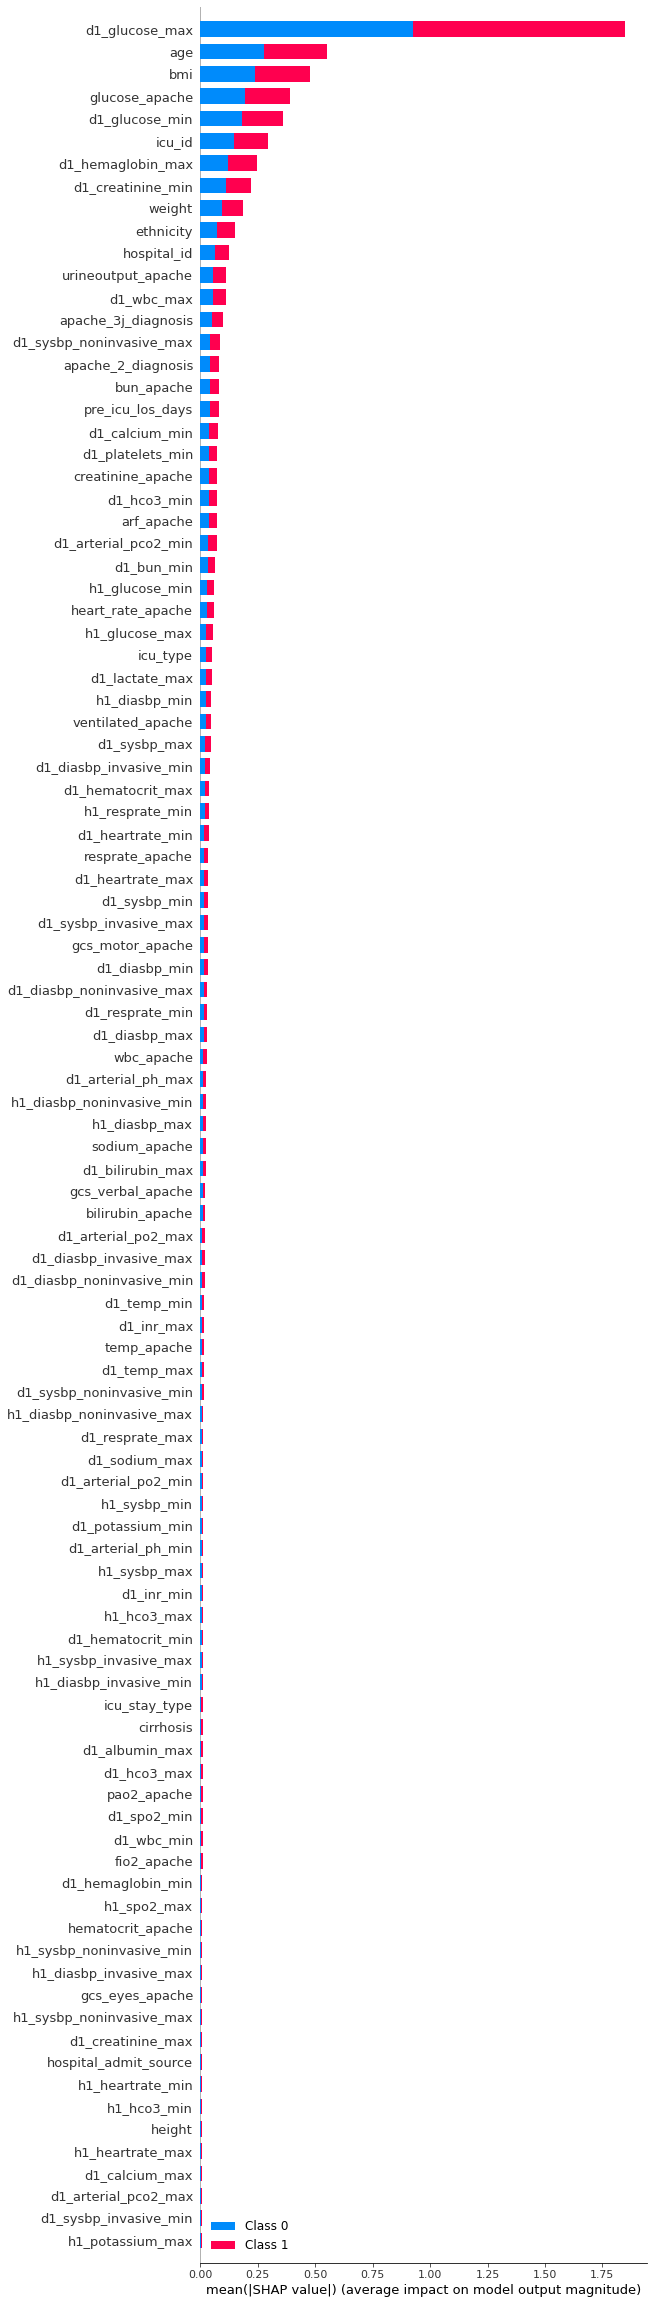

In [146]:
# summarize the effects of all the features
shap.summary_plot(shap_values[:5000], X_train.iloc[:5000], max_display=100)

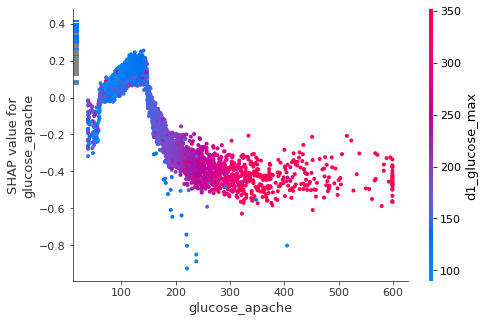

In [151]:
shap.dependence_plot("glucose_apache", shap_values[:5000][0], X_train.iloc[:5000], interaction_index= 'd1_glucose_max')

## Submission dataset

In [110]:
#X = t_data.drop(['encounter_id'], axis=1)#.astype(cat)

In [111]:
y_submit = gbm.predict_proba(X_pred)[:,1]
#y_submit = clf.predict_proba(X[most_important_corrs].fillna(0))[:, 1]

In [113]:
submittion = pd.DataFrame([t_data.encounter_id,y_submit]).T#.set_index('encounter_id')
submittion.encounter_id = submittion.encounter_id.astype('int32')
submittion.set_index('encounter_id',inplace=True)
submittion.columns = ['diabetes_mellitus']
submittion.fillna(0.5).to_csv('SolutionWiDS2021_without_rearranging.csv')

In [91]:
submittion

,diabetes_mellitus
encounter_id,
144740,0.101695
141990,0.336043
142038,0.076617
138628,0.477957
141682,0.114750
...,...
143750,0.077970
143813,0.160934
137126,0.018273


In [238]:
solution_temp = pd.read_csv('SolutionTemplateWiDS2021.csv',index_col=0)

In [239]:
solution_temp['diabetes_mellitus'] = submittion['diabetes_mellitus']

In [240]:
solution_temp.fillna(0.5).to_csv('SolutionWiDS2021.csv')

In [241]:
solution_temp[solution_temp['diabetes_mellitus'].isna()]

,diabetes_mellitus
encounter_id,
136852,NaN


dtype('float64')